# TNT-LLM: Text Mining at Scale

[TNT-LLM](https://arxiv.org/abs/2403.12173) by Wan, et. al describes a taxonomy generation and classification system developed by Microsoft for their Bing Copilot application.

It generates a rich, interpretable taxonomy of user intents (or other categories) from raw conversation logs. This taxonomy can then be used downstream by LLMs to label logs, which in turn can be used as training data to adapt a cheap classifier (such as logistic regression classifier on embeddings) that can be deployed in your app.

TNT-LLM has three main phases:

1. Generate Taxonomy
2. Label Training Data
3. Finetune classifier + deploy

When applying LangGraph in this notebook, we will focus on the first phase: taxonomy generation (blue in the diagram below). We then show how to label and fit the classifier in subsequent steps below.

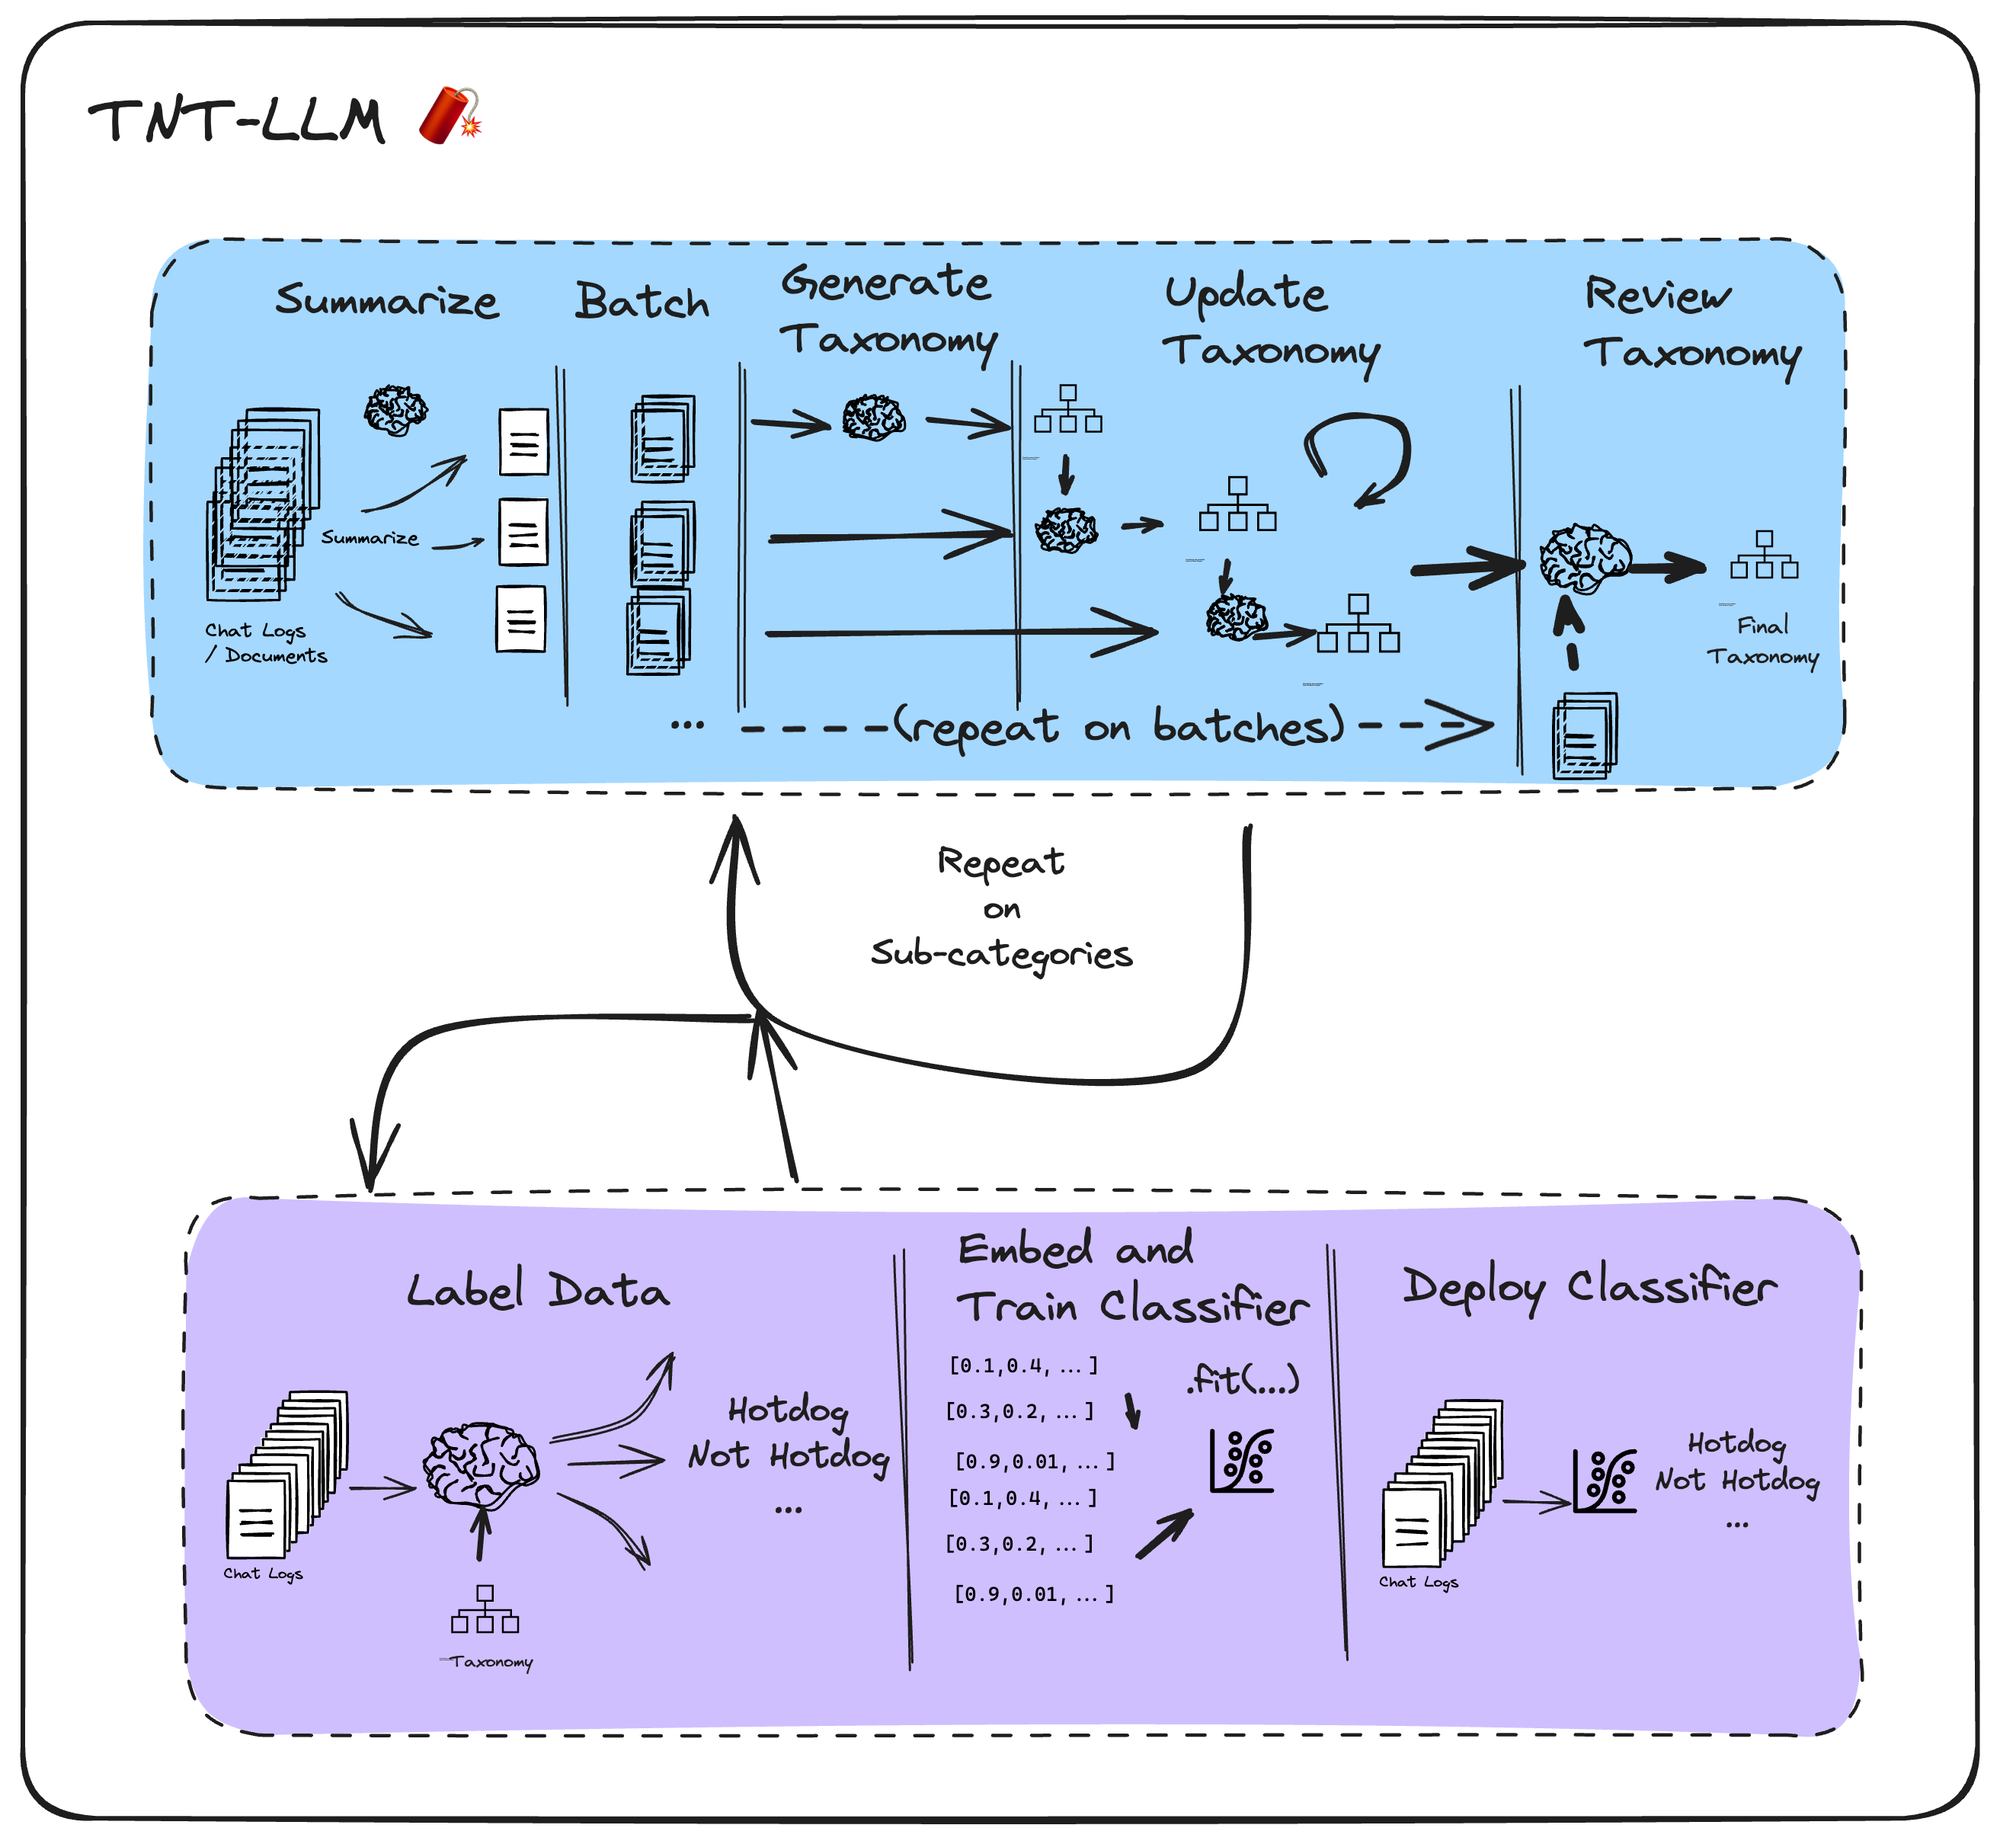
<img src="./img/tnt-llm.png" onerror="this.onerror=null; this.src='../img/tnt-llm.png';"> 


To generate the taxonomy, TNT-LLM proposes 5 steps:

1. **Summarize** chat logs using a lower-cost LLM (batched over all logs in the sample)
2. **Batch** the logs into random minibatches
3. **Generate** an initial taxonomy from the first minibatch
4. **Update** the taxonomy on each subsequent minibatch via a ritique and revise prompt
5. **Review** the final taxonomy, scoring its quality and generating a final value using a final sample.

## Setup

First, let's install our required packages and set our API keys


In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain_anthropic langsmith
# For the embedding-based classifier use in phase 2
%pip install -U sklearn langchain_openai

In [ ]:
import getpass
import os


def _set_env(var: str):
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var + ":")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>   

## Define the graph

### Graph State

Since each node of a StateGraph accepts the state (and returns an updated state), we'll define that at the outset.

Our flow takes in a list of documents, batches them, and then generates and refines candidate taxonomies as interpretable "clusters".


In [69]:
import logging
import operator
from typing import Annotated, List, Optional, TypedDict

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("tnt-llm")


class Doc(TypedDict):
    id: str
    content: str
    summary: Optional[str]
    explanation: Optional[str]
    category: Optional[str]


class TaxonomyGenerationState(TypedDict):
    # The raw docs; we inject summaries within them in the first step
    documents: List[Doc]
    # Indices to be concise
    minibatches: List[List[int]]
    # Candidate Taxonomies (full trajectory)
    clusters: Annotated[List[List[dict]], operator.add]

### Define nodes

#### 1. Summarize Docs

Chat logs can get quite long. Our taxonomy generation step needs to see large, diverse minibatches to be able to adequately capture the distribution of categories. To ensure they can all fit efficiently into the context window, we first summarize each chat log. Downstream steps will use these summaries instead of the raw doc content.


In [8]:
import re

from langchain import hub
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough

summary_prompt = hub.pull("wfh/tnt-llm-summary-generation").partial(
    summary_length=20, explanation_length=30
)


def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"

    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)

    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""

    return {"summary": summary, "explanation": explanation}


summary_llm_chain = (
    summary_prompt
    | ChatAnthropic(model="claude-3-haiku-20240307")
    | StrOutputParser()
    # Customize the tracing name for easier organization
).with_config(run_name="GenerateSummary")
summary_chain = summary_llm_chain | parse_summary


# Now combine as a "map" operation in a map-reduce chain
# Input: state
# Output: state U summaries
# Processes docs in parallel
def get_content(state: TaxonomyGenerationState):
    docs = state["documents"]
    return [{"content": doc["content"]} for doc in docs]


map_step = RunnablePassthrough.assign(
    summaries=get_content
    # This effectively creates a "map" operation
    # Note you can make this more robust by handling individual errors
    | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
)


def reduce_summaries(combined: dict) -> TaxonomyGenerationState:
    summaries = combined["summaries"]
    documents = combined["documents"]
    return {
        "documents": [
            {
                "id": doc["id"],
                "content": doc["content"],
                "summary": summ_info["summary"],
                "explanation": summ_info["explanation"],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }


# This is actually the node itself!
map_reduce_chain = map_step | reduce_summaries

#### 2. Split into Minibatches

Each minibatch contains a random sample of docs. This lets the flow identify inadequacies in the current taxonomy using new data.


In [9]:
import random


def get_minibatches(state: TaxonomyGenerationState, config: RunnableConfig):
    batch_size = config["configurable"].get("batch_size", 200)
    original = state["documents"]
    indices = list(range(len(original)))
    random.shuffle(indices)
    if len(indices) < batch_size:
        # Don't pad needlessly if we can't fill a single batch
        return [indices]

    num_full_batches = len(indices) // batch_size

    batches = [
        indices[i * batch_size : (i + 1) * batch_size] for i in range(num_full_batches)
    ]

    leftovers = len(indices) % batch_size
    if leftovers:
        last_batch = indices[num_full_batches * batch_size :]
        elements_to_add = batch_size - leftovers
        last_batch += random.sample(indices, elements_to_add)
        batches.append(last_batch)

    return {
        "minibatches": batches,
    }

#### 3.a Taxonomy Generation Utilities

This section of the graph is a generate -> update 🔄 -> review cycle. Each node shares a LOT of logic, which we have factored out into the shared functions below.


In [11]:
from typing import Dict

from langchain_core.runnables import Runnable


def parse_taxa(output_text: str) -> Dict:
    """Extract the taxonomy from the generated output."""
    cluster_matches = re.findall(
        r"\s*<id>(.*?)</id>\s*<name>(.*?)</name>\s*<description>(.*?)</description>\s*",
        output_text,
        re.DOTALL,
    )
    clusters = [
        {"id": id.strip(), "name": name.strip(), "description": description.strip()}
        for id, name, description in cluster_matches
    ]
    # We don't parse the explanation since it isn't used downstream
    return {"clusters": clusters}


def format_docs(docs: List[Doc]) -> str:
    xml_table = "<conversations>\n"
    for doc in docs:
        xml_table += f'<conv_summ id={doc["id"]}>{doc["summary"]}</conv_summ>\n'
    xml_table += "</conversations>"
    return xml_table


def format_taxonomy(clusters):
    xml = "<cluster_table>\n"
    for label in clusters:
        xml += "  <cluster>\n"
        xml += f'    <id>{label["id"]}</id>\n'
        xml += f'    <name>{label["name"]}</name>\n'
        xml += f'    <description>{label["description"]}</description>\n'
        xml += "  </cluster>\n"
    xml += "</cluster_table>"
    return xml


def invoke_taxonomy_chain(
    chain: Runnable,
    state: TaxonomyGenerationState,
    config: RunnableConfig,
    mb_indices: List[int],
) -> TaxonomyGenerationState:
    configurable = config["configurable"]
    docs = state["documents"]
    minibatch = [docs[idx] for idx in mb_indices]
    data_table_xml = format_docs(minibatch)

    previous_taxonomy = state["clusters"][-1] if state["clusters"] else []
    cluster_table_xml = format_taxonomy(previous_taxonomy)

    updated_taxonomy = chain.invoke(
        {
            "data_xml": data_table_xml,
            "use_case": configurable["use_case"],
            "cluster_table_xml": cluster_table_xml,
            "suggestion_length": configurable.get("suggestion_length", 30),
            "cluster_name_length": configurable.get("cluster_name_length", 10),
            "cluster_description_length": configurable.get(
                "cluster_description_length", 30
            ),
            "explanation_length": configurable.get("explanation_length", 20),
            "max_num_clusters": configurable.get("max_num_clusters", 25),
        }
    )

    return {
        "clusters": [updated_taxonomy["clusters"]],
    }

#### 3. Generate initial taxonomy


In [40]:
# We will share an LLM for each step of the generate -> update -> review cycle
# You may want to consider using Opus or another more powerful model for this
taxonomy_generation_llm = ChatAnthropic(
    model="claude-3-haiku-20240307", max_tokens_to_sample=2000
)


## Initial generation
taxonomy_generation_prompt = hub.pull("wfh/tnt-llm-taxonomy-generation").partial(
    use_case="Generate the taxonomy that can be used to label the user intent in the conversation.",
)

taxa_gen_llm_chain = (
    taxonomy_generation_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="GenerateTaxonomy")


generate_taxonomy_chain = taxa_gen_llm_chain | parse_taxa


def generate_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    return invoke_taxonomy_chain(
        generate_taxonomy_chain, state, config, state["minibatches"][0]
    )

#### 4. Update Taxonomy

This is a "critique -> revise" step that is repeated N times.


In [33]:
taxonomy_update_prompt = hub.pull("wfh/tnt-llm-taxonomy-update")

taxa_update_llm_chain = (
    taxonomy_update_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="UpdateTaxonomy")


update_taxonomy_chain = taxa_update_llm_chain | parse_taxa


def update_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    which_mb = len(state["clusters"]) % len(state["minibatches"])
    return invoke_taxonomy_chain(
        update_taxonomy_chain, state, config, state["minibatches"][which_mb]
    )

#### 5. Review Taxonomy

This runs once we've processed all the minibatches.


In [34]:
taxonomy_review_prompt = hub.pull("wfh/tnt-llm-taxonomy-review")

taxa_review_llm_chain = (
    taxonomy_review_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="ReviewTaxonomy")


review_taxonomy_chain = taxa_review_llm_chain | parse_taxa


def review_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    batch_size = config["configurable"].get("batch_size", 200)
    original = state["documents"]
    indices = list(range(len(original)))
    random.shuffle(indices)
    return invoke_taxonomy_chain(
        review_taxonomy_chain, state, config, indices[:batch_size]
    )

### Compile the Graph

With all the functionality defined, we can build the graph!


In [35]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(TaxonomyGenerationState)
graph.add_node("summarize", map_reduce_chain)
graph.add_node("get_minibatches", get_minibatches)
graph.add_node("generate_taxonomy", generate_taxonomy)
graph.add_node("update_taxonomy", update_taxonomy)
graph.add_node("review_taxonomy", review_taxonomy)

graph.add_edge("summarize", "get_minibatches")
graph.add_edge("get_minibatches", "generate_taxonomy")
graph.add_edge("generate_taxonomy", "update_taxonomy")


def should_review(state: TaxonomyGenerationState) -> str:
    num_minibatches = len(state["minibatches"])
    num_revisions = len(state["clusters"])
    if num_revisions < num_minibatches:
        return "update_taxonomy"
    return "review_taxonomy"


graph.add_conditional_edges(
    "update_taxonomy",
    should_review,
    # Optional (but required for the diagram to be drawn correctly below)
    {"update_taxonomy": "update_taxonomy", "review_taxonomy": "review_taxonomy"},
)
graph.add_edge("review_taxonomy", END)

graph.add_edge(START, "summarize")
app = graph.compile()

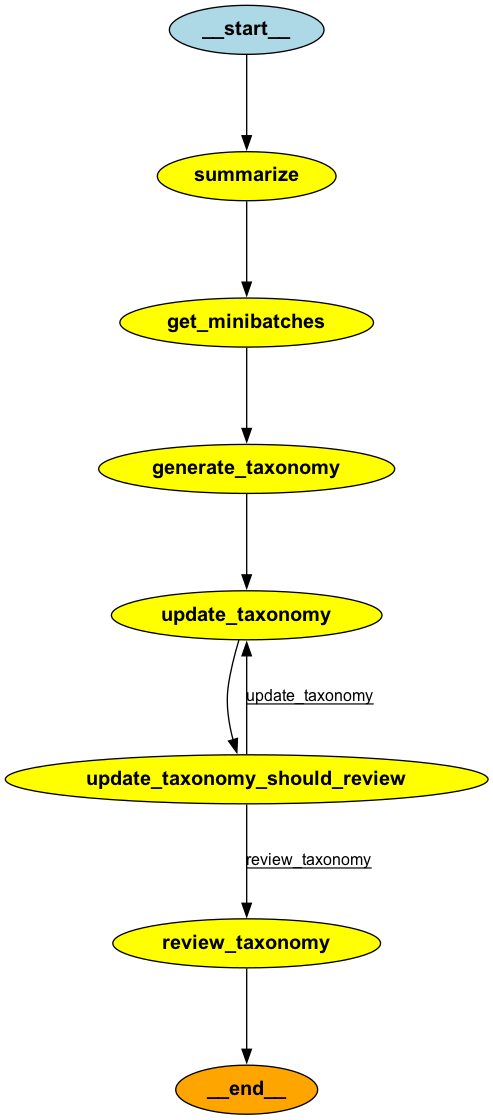

In [36]:
from IPython.display import Image

Image(app.get_graph().draw_png())

## Use the graph

The docs can contain **any** content, but we've found it works really well on chat bot logs, such as those captured by [LangSmith](https://smith.langchain.com).

We will use that as an example below. Update the `project_name` to your own LangSmith project.

You will likely have to customize the `run_to_doc` function below, since your expected keys may differ from those of this notebook's author.


In [193]:
from datetime import datetime, timedelta

from langsmith import Client

project_name = "YOUR PROJECT NAME"  # Update to your own project
client = Client()

past_week = datetime.now() - timedelta(days=7)
runs = list(
    client.list_runs(
        project_name=project_name,
        filter="eq(is_root, true)",
        start_time=past_week,
        # We only need to return the inputs + outputs
        select=["inputs", "outputs"],
    )
)


# Convert the langsmith traces to our graph's Doc object.
def run_to_doc(run) -> Doc:
    turns = []
    idx = 0
    for turn in run.inputs.get("chat_history") or []:
        key, value = next(iter(turn.items()))
        turns.append(f"<{key} idx={idx}>\n{value}\n</{key}>")
        idx += 1
    turns.append(
        f"""
<human idx={idx}>
{run.inputs['question']}
</human>"""
    )
    if run.outputs and run.outputs["output"]:
        turns.append(
            f"""<ai idx={idx+1}>
{run.outputs['output']}
</ai>"""
        )
    return {
        "id": str(run.id),
        "content": ("\n".join(turns)),
    }

#### Invoke

Now convert the runs to docs and kick off your graph flow. This will take some time! The summary step takes the longest. If you want to speed things up, you could try splitting the load across model providers.


In [21]:
from langchain.cache import InMemoryCache
from langchain.globals import set_llm_cache

# Optional. If you are running into errors or rate limits and want to avoid repeated computation,
# you can set this while debugging

set_llm_cache(InMemoryCache())

In [ ]:
# We will randomly sample down to 1K docs to speed things up
docs = [run_to_doc(run) for run in runs if run.inputs]
docs = random.sample(docs, min(len(docs), 1000))
use_case = (
    "Generate the taxonomy that can be used both to label the user intent"
    " as well as to identify any required documentation (references, how-tos, etc.)"
    " that would benefit the user."
)

stream = app.stream(
    {"documents": docs},
    {
        "configurable": {
            "use_case": use_case,
            # Optional:
            "batch_size": 400,
            "suggestion_length": 30,
            "cluster_name_length": 10,
            "cluster_description_length": 30,
            "explanation_length": 20,
            "max_num_clusters": 25,
        },
        # We batch summarize the docs. To avoid getting errors, we will limit the
        # degree of parallelism to permit.
        "max_concurrency": 2,
    },
)

for step in stream:
    node, state = next(iter(step.items()))
    print(node, str(state)[:20] + " ...")

## Final Result

Below, render the final result as markdown:


In [202]:
from IPython.display import Markdown


def format_taxonomy_md(clusters):
    md = "## Final Taxonomy\n\n"
    md += "| ID | Name | Description |\n"
    md += "|----|------|-------------|\n"

    # Fill the table with cluster data
    for label in clusters:
        id = label["id"]
        name = label["name"].replace(
            "|", "\\|"
        )  # Escape any pipe characters within the content
        description = label["description"].replace(
            "|", "\\|"
        )  # Escape any pipe characters
        md += f"| {id} | {name} | {description} |\n"

    return md


Markdown(format_taxonomy_md(step["__end__"]["clusters"][-1]))

## Final Taxonomy

| ID | Name | Description |
|----|------|-------------|
| 1 | Troubleshooting Network Connectivity Issues | Resolving problems with DNS, network connections, and GitHub extension activation. |
| 2 | Extracting and Analyzing Data | Retrieving and processing data from various sources like text files, databases, and APIs. |
| 3 | Providing Healthcare Insights | Generating medical diagnosis, symptom checking, drug information, and skin condition analysis. |
| 4 | Configuring and Optimizing Models | Adjusting model parameters and hyperparameters to improve performance for a given task. |
| 5 | Generating Creative Poetry | Creating poems using language models and AI-powered tools. |
| 6 | Interacting with Databases | Querying databases, extracting data, and managing errors during data processing. |
| 7 | Querying Vector Databases | Interacting with vector databases like Milvus to store and retrieve high-dimensional data. |
| 8 | Generating Synthetic Data | Creating synthetic data using language models and machine learning techniques. |
| 9 | Integrating Tools and Workflows | Incorporating various tools and libraries into a cohesive workflow for different tasks. |
| 10 | Improving Information Retrieval | Storing and querying multiple vectors per document for better semantic understanding. |
| 11 | Processing Documents and Extracting Text | Parsing and extracting text from various document formats like PDF, DOCX, and HTML. |
| 12 | Building Local Knowledge Bases | Creating knowledge bases from text files, handling text splitting, embeddings, and storage. |
| 13 | Optimizing Conversational Retrieval | Troubleshooting and improving the performance of the ConversationalRetrievalChain in LangChain. |
| 14 | Connecting Databases and Using Agents | Connecting to databases, using agents, and understanding the differences between agent types. |
| 15 | Introspecting LangChain Tools | Accessing and retrieving details about the functions and source code of LangChain tools. |
| 16 | Generating Styled Answers with Retrieval Augmentation | Creating a QA system that generates well-cited answers in a specific style. |
| 17 | Using ZERO_SHOT_REACT_DESCRIPTION Agents | Applying the ZERO_SHOT_REACT_DESCRIPTION agent type in LangChain for chat models. |
| 18 | Automating Microlearning Course Creation | Generating microlearning courses based on input parameters like topic, volume, and learning style. |
| 19 | Integrating with Chroma Vector Store | Storing and retrieving data in the Chroma vector database, including handling document embeddings. |
| 20 | Managing LangChain Callback Tokens | Understanding and utilizing the callback token feature in the LCEL chain. |
| 21 | Troubleshooting FastAPI Deployments | Resolving issues with deploying a React app with a FastAPI backend. |
| 22 | Analyzing Data with LangChain Agents | Using LangChain agents to interact with Pandas and Spark DataFrames for data exploration. |
| 23 | Implementing the OpenAI Chat API | Implementing the OpenAI chat completion API and understanding the required inputs and outputs. |
| 24 | Comparing LangChain and LLMIndex | Evaluating the differences between LangChain and LLMIndex, including their UI support for Markdown. |
| 25 | Suppressing Tools in AgentExecutor | Temporarily disabling tools in an AgentExecutor for a fixed number of invocations. |


## Phase 2: Labeling

Now that we have our taxonomy, it's time to label a subset of our data to train a classifier.

Input classification can be useful for anything from in-line prompt optimization (tailor the prompt for each classified intent), to system improvements (identifying categories for which the system doesn't produce good responses) to product analytics (understand which intent categories could be improved to drive profits).

The problem is that LLM-based tagging can be expensive.

Embeddings can be ~100x cheaper to compute, and a simple logistic regression classifier on top of that would add negligible cost.

Let's tag and train a classifier!

#### Label Training Data

Use an LLM to label the data in a fully-automated fashion. For better accuracy, you can sample a portion of the results to label by hand as well to verify the quality.


In [89]:
labeling_prompt = hub.pull("wfh/tnt-llm-classify")

labeling_llm = ChatAnthropic(model="claude-3-haiku-20240307", max_tokens_to_sample=2000)
labeling_llm_chain = (labeling_prompt | labeling_llm | StrOutputParser()).with_config(
    run_name="ClassifyDocs"
)


def parse_labels(output_text: str) -> Dict:
    """Parse the generated labels from the predictions."""
    category_matches = re.findall(
        r"\s*<category>(.*?)</category>.*",
        output_text,
        re.DOTALL,
    )
    categories = [{"category": category.strip()} for category in category_matches]
    if len(categories) > 1:
        logger.warning(f"Multiple selected categories: {categories}")
    label = categories[0]
    stripped = re.sub(r"^\d+\.\s*", "", label["category"]).strip()
    return {"category": stripped}


labeling_chain = labeling_llm_chain | parse_labels

In [148]:
final_taxonomy = step["__end__"]["clusters"][-1]
xml_taxonomy = format_taxonomy(final_taxonomy)
results = labeling_chain.batch(
    [
        {
            "content": doc["content"],
            "taxonomy": xml_taxonomy,
        }
        for doc in docs
    ],
    {"max_concurrency": 5},
    return_exceptions=True,
)
# Update the docs to include the categories
updated_docs = [{**doc, **category} for doc, category in zip(docs, results)]

In [ ]:
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OPENAI_API_KEY: ")

In [149]:
from langchain_openai import OpenAIEmbeddings

# Consider using other embedding models here too!
encoder = OpenAIEmbeddings(model="text-embedding-3-large")
vectors = encoder.embed_documents([doc["content"] for doc in docs])
embedded_docs = [{**doc, "embedding": v} for doc, v in zip(updated_docs, vectors)]

#### Train Classifier

Now that we've extracted the features from the text, we can generate the classifier on them.


In [196]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Create a dictionary mapping category names to their indices in the taxonomy
category_to_index = {d["name"]: i for i, d in enumerate(final_taxonomy)}
category_to_index["Other"] = len(category_to_index)
# Convert category strings to numeric labels
labels = [
    category_to_index.get(d["category"], category_to_index["Other"])
    for d in embedded_docs
]

label_vectors = [d["embedding"] for d in embedded_docs]

X_train, X_test, y_train, y_test = train_test_split(
    label_vectors, labels, test_size=0.2, random_state=42
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Weight the classes to partially handle imbalanced data
model = LogisticRegression(class_weight=class_weight_dict)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
train_f1 = f1_score(y_train, train_preds, average="weighted")
test_f1 = f1_score(y_test, test_preds, average="weighted")

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Train F1 Score: {train_f1:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")

Train Accuracy: 0.515
Test Accuracy: 0.330
Train F1 Score: 0.493
Test F1 Score: 0.335


## Phase 3: Deploy

Now that you have your classifier, you can easily deploy it and apply to future runs! All you need is to embed the input and apply your LogisticRegression classifier. Let's try it. We will use python's [joblib](https://joblib.readthedocs.io/en/stable/) library to serialize our sklearn classifier. Below is an example:


In [197]:
from joblib import dump as jl_dump

categories = list(category_to_index)

# Save the model and categories to a file
with open("model.joblib", "wb") as file:
    jl_dump((model, categories), file)

#### To deploy

When deploying, you can load the classifier and initialize your embeddings encoder. They fit together easily using LCEL:


In [198]:
from joblib import load as jl_load
from langchain_openai import OpenAIEmbeddings

loaded_model, loaded_categories = jl_load("model.joblib")
encoder = OpenAIEmbeddings(model="text-embedding-3-large")


def get_category_name(predictions):
    return [loaded_categories[pred] for pred in predictions]


classifier = (
    RunnableLambda(encoder.embed_documents, encoder.aembed_documents)
    | loaded_model.predict
    | get_category_name
)

#### Example:

Assuming you've had some more data come in, you can fetch it and apply it below


In [194]:
client = Client()

past_5_min = datetime.now() - timedelta(minutes=5)
runs = list(
    client.list_runs(
        project_name=project_name,
        filter="eq(is_root, true)",
        start_time=past_5_min,
        # We only need to return the inputs + outputs
        select=["inputs", "outputs"],
        limit=100,
    )
)
docs = [run_to_doc(r) for r in runs]

In [199]:
classes = classifier.invoke([doc["content"] for doc in docs])
print(classes[:2])

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['Interacting with Databases', 'Optimizing Conversational Retrieval']


## Conclusion

Congrats on implementing TNT-LLM! While most folks use clustering-based approaches like LDA, k-means, etc. it can often be hard to really interpret what each cluster represents. TNT-LLM generates human-interpretable labels you can use downstream to monitor and improve your application.

The technique also lends itself to hierarchical sub-categorizing: once you have the above taxonomy, use it to label your data, then on each sub-category, generate a new taxonomy using a similar technique to the one described above!
